In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/shauryasighadia/Desktop/sem6/Time Series Analysis/Mini Project/data/GlobalLandTemperaturesByMajorCity.csv')
data = data[data.City == 'Madras']
data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
135716,1796-01-01,24.252,2.433,Madras,India,13.66N,80.09E
135717,1796-02-01,25.579,1.423,Madras,India,13.66N,80.09E
135718,1796-03-01,27.196,2.591,Madras,India,13.66N,80.09E
135719,1796-04-01,30.168,1.846,Madras,India,13.66N,80.09E
135720,1796-05-01,32.682,1.263,Madras,India,13.66N,80.09E


In [3]:
data['Date'] = pd.to_datetime(data['dt'])
data.drop(['AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude', 'dt'], axis = 1, inplace = True)
data = data.set_index('Date')
data = data['1970':'2012']
data.head()

,AverageTemperature
Date,
1970-01-01,24.745
1970-02-01,26.320
1970-03-01,28.833
1970-04-01,30.676
1970-05-01,32.785


In [4]:
data.isnull().sum()

AverageTemperature    0
dtype: int64

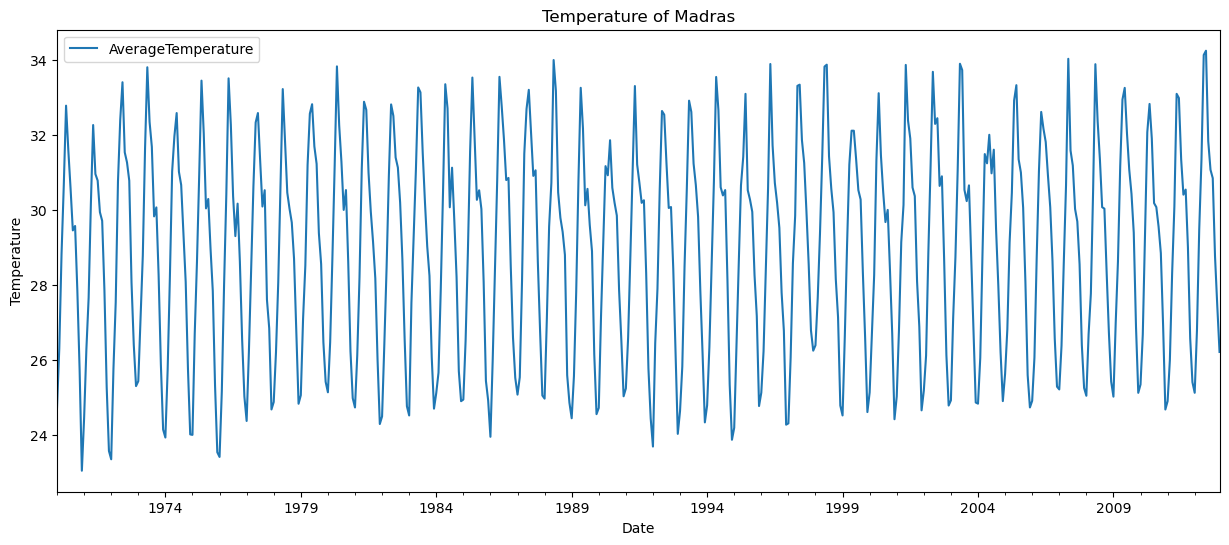

In [5]:
data.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature of Madras')
plt.show()

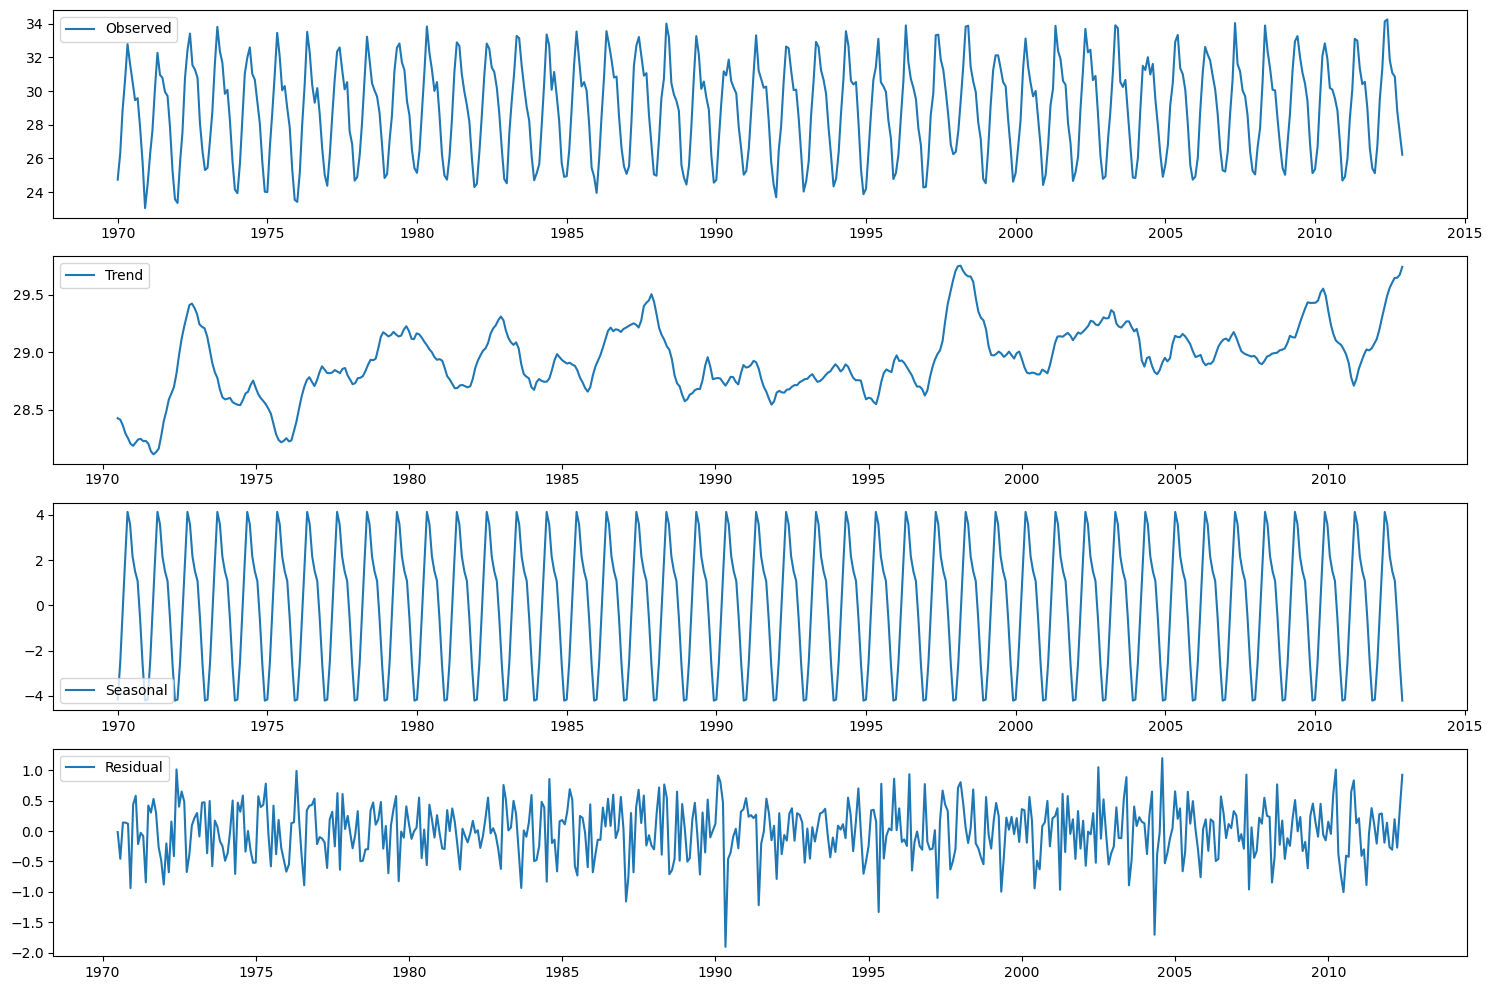

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data)
observed = result.observed
trend = result.trend
seasonal = result.seasonal
residual = result.resid
plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

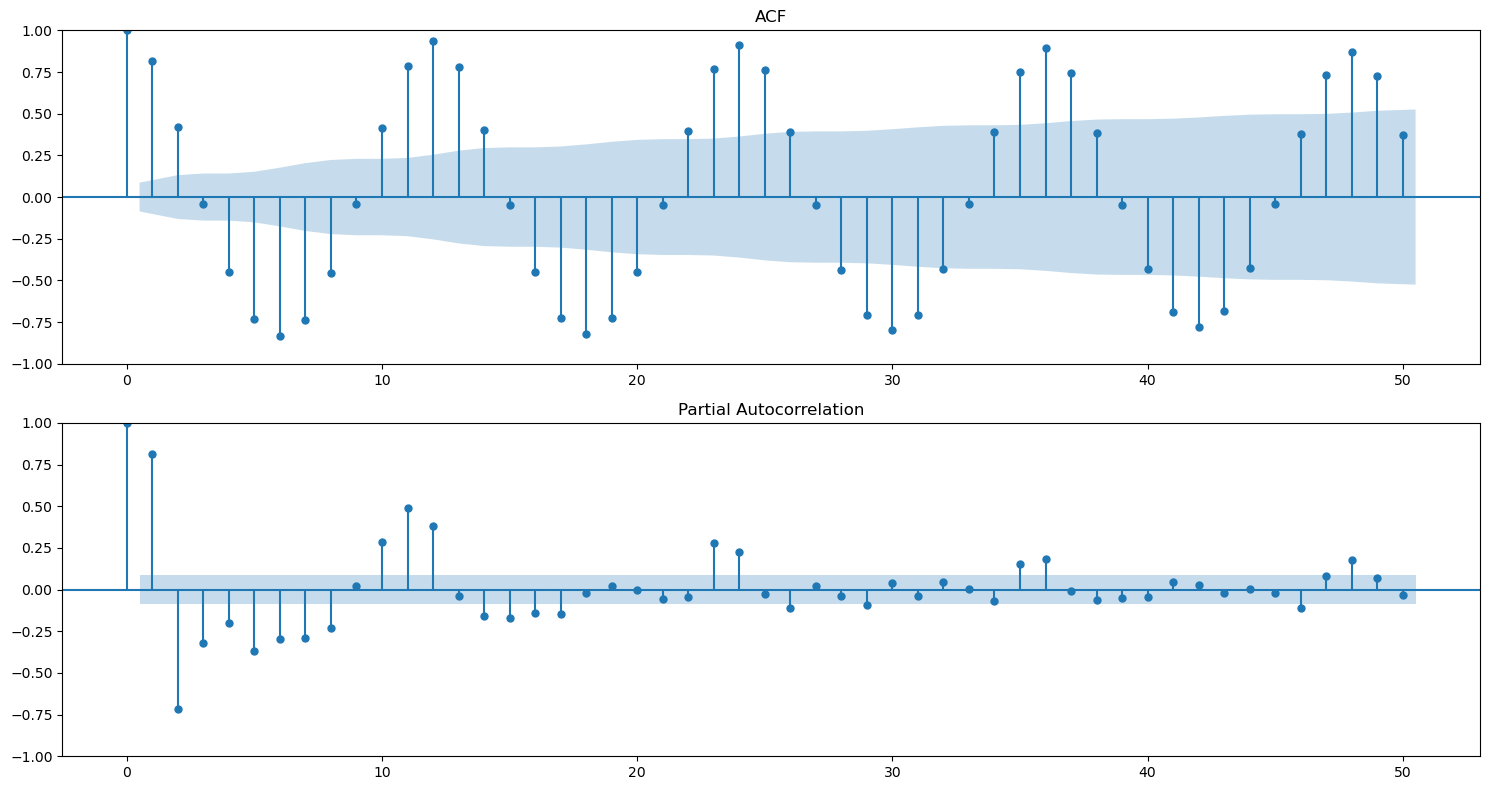

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 8))
plt.subplot(211)
plot_acf(data, lags=50, ax=plt.gca())
plt.title('ACF')
plt.subplot(212)
plt.title('PACF')
plot_pacf(data, lags=50, ax=plt.gca())
plt.tight_layout()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(data, autolag='AIC')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print(f'Critical Values: {adf[4]}')

ADF Statistic: -5.304088623953751
p-value: 5.369876122933898e-06
Critical Values: {'1%': -3.4435228622952065, '5%': -2.867349510566146, '10%': -2.569864247011056}


In [9]:
from statsmodels.tsa.stattools import kpss

kpss_stat = kpss(data, regression='c', nlags='auto')
print(f'KPSS Statistic: {kpss_stat[0]}')
print(f'p-value: {kpss_stat[1]}')
print(f'Critical Values: {kpss_stat[3]}')

KPSS Statistic: 0.06488393194646136
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [10]:
y = data['AverageTemperature'].resample('MS').mean()
train = y['1970':'2009']
test = y['2010':]

In [11]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(train, seasonal = True, m = 12, stepwise = False, trace = 1, random_state = 10)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2354.798, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1930.367, Time=0.33 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1680.358, Time=0.78 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1085.758, Time=0.92 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1098.656, Time=2.62 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1936.461, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1645.924, Time=0.17 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1503.776, Time=0.69 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1130.089, Time=0.59 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1058.523, Time=0.84 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1110.504, Time=3.06 sec
 ARIMA(0,0,1)(2

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order = (1, 0, 0), seasonal_order = (1, 0, 1, 12), enforce_stationarity = False, enforce_invertibility = False)
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50403D+00    |proj g|=  4.75625D-01

At iterate    5    f=  1.03673D+00    |proj g|=  4.55393D-01

At iterate   10    f=  9.02780D-01    |proj g|=  2.78978D+01

At iterate   15    f=  8.34173D-01    |proj g|=  1.90878D+01

At iterate   20    f=  7.93518D-01    |proj g|=  1.70248D-02

At iterate   25    f=  7.93489D-01    |proj g|=  9.02832D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                   AverageTemperature   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -380.875
Date:                              Mon, 20 May 2024   AIC                            769.749
Time:                                      21:41:28   BIC                            786.334
Sample:                                  01-01-1970   HQIC                           776.276
                                       - 12-01-2009                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2957      0.044      6.672      0.000       0.209       0.383
ar.S.L12       1.0004      0.000   9929.953      0.000       1.000       1.001
ma.S.L12      -1.0000    160.166     -0.006      0.995    -314.921     312.921
sigma2         0.2721     43.587      0.006      0.995     -85.156      85.700
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                35.37
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.33
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

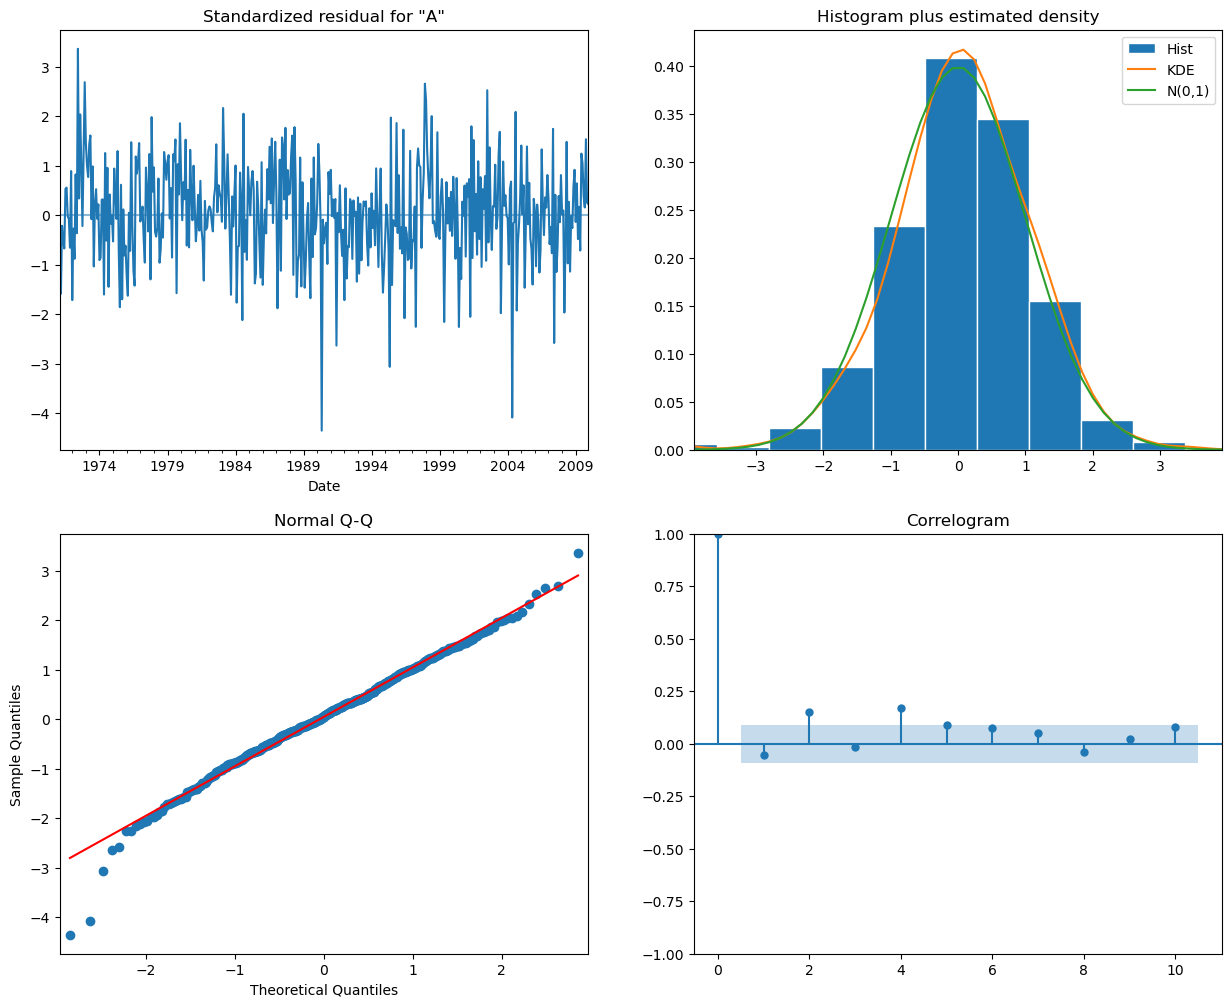

In [13]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

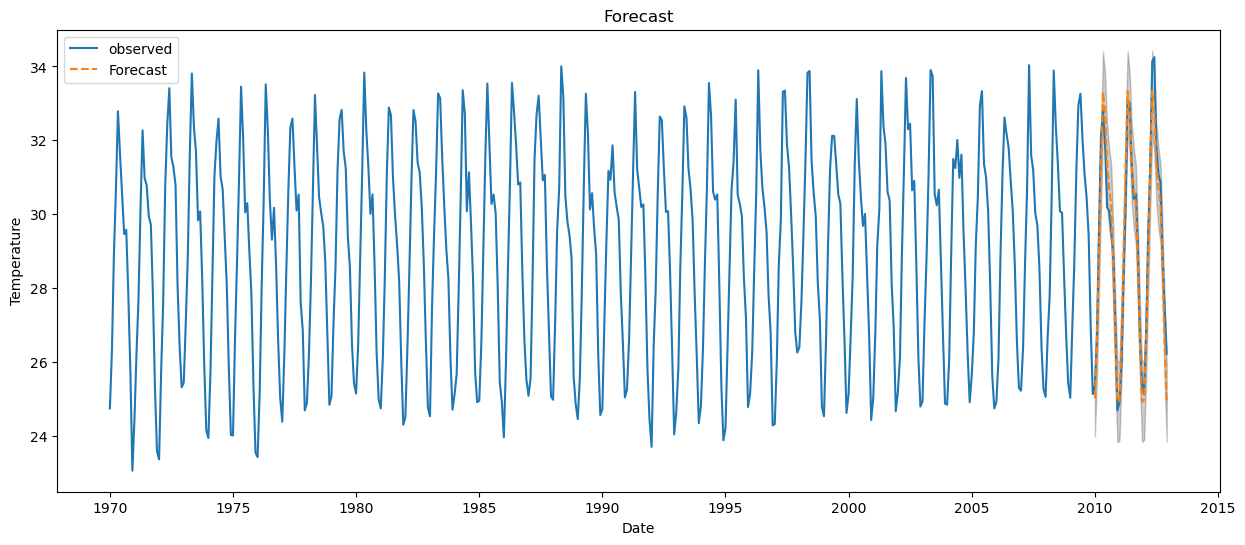

In [14]:
forecast = result.get_forecast(steps = len(test))
plt.figure(figsize=(15, 6))
plt.plot(y.index, y, label='observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', linestyle='--')
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower AverageTemperature'], forecast.conf_int()['upper AverageTemperature'], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Forecast')
plt.legend()
plt.show()

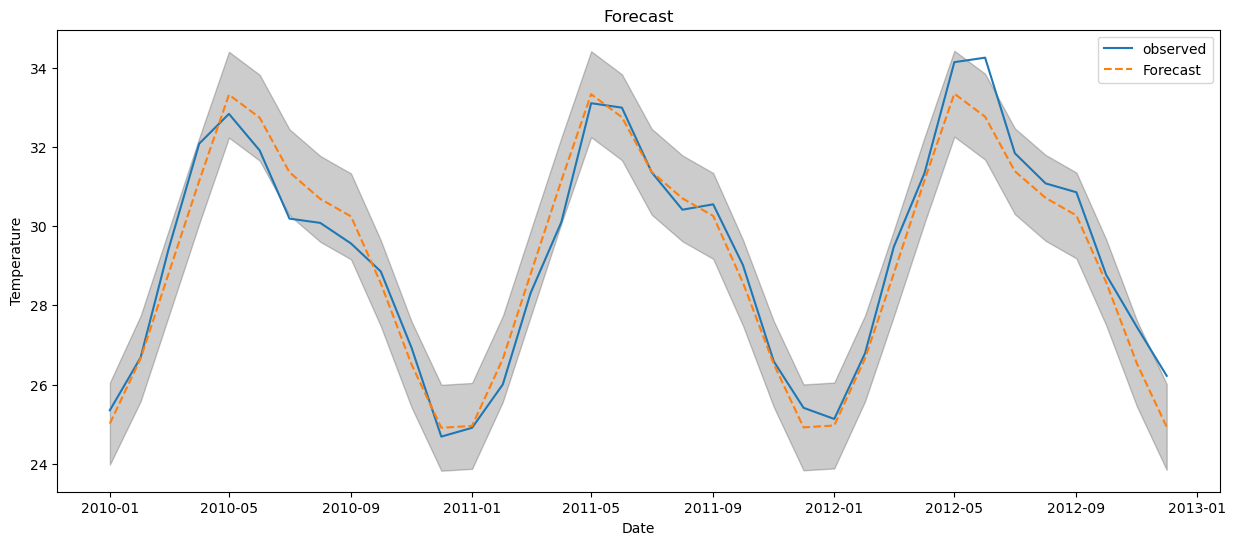

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(y['2010':].index, y['2010':], label='observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', linestyle='--')
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower AverageTemperature'], forecast.conf_int()['upper AverageTemperature'], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Forecast')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test, forecast.predicted_mean)
rmse = sqrt(mse)

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')

RMSE: 0.6211939081843411
MSE: 0.3858818715653356
